In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

set_config(display='diagram')

In [27]:
df = pd.read_parquet('../Data/Multi_County_Data/Mutli_County_Weather_And_DSCI')

In [28]:
df

,county,quarter,month,year,dayofyear,dayofmonth,date_offset,week,season,PRCP,TAVG,TMAX,TMIN,DSCI
date,,,,,,,,,,,,,,
2001-01-04,Colquitt_County,1,1,2001,2,2,1082,1,Winter,0.000000,38.857143,52.857143,24.857143,184
2001-01-04,Cook_County,1,1,2001,2,2,1082,1,Winter,0.000000,36.333329,47.869048,24.797619,100
2001-01-04,Worth_County,1,1,2001,2,2,1082,1,Winter,0.000000,36.152386,47.866667,24.438095,200
2001-01-04,Tift_County,1,1,2001,2,2,1082,1,Winter,0.000000,34.857143,46.428571,23.285714,144
2001-01-04,Irwin_County,1,1,2001,2,2,1082,1,Winter,0.000000,35.800000,47.621429,23.978571,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29,Colquitt_County,4,12,2022,361,27,907,52,Winter,0.019444,45.962500,59.975000,31.950000,200
2022-12-29,Irwin_County,4,12,2022,361,27,907,52,Winter,0.010278,46.350000,60.066667,32.633333,148
2022-12-29,Tift_County,4,12,2022,361,27,907,52,Winter,0.003333,44.522233,58.616667,30.427778,200


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6888 entries, 2001-01-04 to 2022-12-29
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   county       6888 non-null   object  
 1   quarter      6888 non-null   int64   
 2   month        6888 non-null   int64   
 3   year         6888 non-null   int64   
 4   dayofyear    6888 non-null   int64   
 5   dayofmonth   6888 non-null   int64   
 6   date_offset  6888 non-null   int64   
 7   week         6888 non-null   int64   
 8   season       6888 non-null   category
 9   PRCP         6888 non-null   float64 
 10  TAVG         6888 non-null   float64 
 11  TMAX         6888 non-null   float64 
 12  TMIN         6888 non-null   float64 
 13  DSCI         6888 non-null   int64   
dtypes: category(1), float64(4), int64(8), object(1)
memory usage: 760.3+ KB


In [30]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df['season'] = le.fit_transform(df['season'])
df['county'] = le.fit_transform(df['county'])
df.season.value_counts()
df.county.value_counts()


0    1148
1    1148
5    1148
3    1148
2    1148
4    1148
Name: county, dtype: int64

In [31]:
df

,county,quarter,month,year,dayofyear,dayofmonth,date_offset,week,season,PRCP,TAVG,TMAX,TMIN,DSCI
date,,,,,,,,,,,,,,
2001-01-04,0,1,1,2001,2,2,1082,1,3,0.000000,38.857143,52.857143,24.857143,184
2001-01-04,1,1,1,2001,2,2,1082,1,3,0.000000,36.333329,47.869048,24.797619,100
2001-01-04,5,1,1,2001,2,2,1082,1,3,0.000000,36.152386,47.866667,24.438095,200
2001-01-04,3,1,1,2001,2,2,1082,1,3,0.000000,34.857143,46.428571,23.285714,144
2001-01-04,2,1,1,2001,2,2,1082,1,3,0.000000,35.800000,47.621429,23.978571,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29,0,4,12,2022,361,27,907,52,3,0.019444,45.962500,59.975000,31.950000,200
2022-12-29,2,4,12,2022,361,27,907,52,3,0.010278,46.350000,60.066667,32.633333,148
2022-12-29,3,4,12,2022,361,27,907,52,3,0.003333,44.522233,58.616667,30.427778,200


In [32]:
df = df.astype(np.float32)
df

,county,quarter,month,year,dayofyear,dayofmonth,date_offset,week,season,PRCP,TAVG,TMAX,TMIN,DSCI
date,,,,,,,,,,,,,,
2001-01-04,0.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,38.857143,52.857143,24.857143,184.0
2001-01-04,1.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,36.333328,47.869049,24.797619,100.0
2001-01-04,5.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,36.152386,47.866665,24.438095,200.0
2001-01-04,3.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,34.857143,46.428570,23.285715,144.0
2001-01-04,2.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,35.799999,47.621429,23.978571,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29,0.0,4.0,12.0,2022.0,361.0,27.0,907.0,52.0,3.0,0.019444,45.962502,59.974998,31.950001,200.0
2022-12-29,2.0,4.0,12.0,2022.0,361.0,27.0,907.0,52.0,3.0,0.010278,46.349998,60.066666,32.633335,148.0
2022-12-29,3.0,4.0,12.0,2022.0,361.0,27.0,907.0,52.0,3.0,0.003333,44.522232,58.616665,30.427778,200.0


In [124]:
df = df.drop(['dayofyear','dayofmonth','date_offset','quarter'], axis=1)

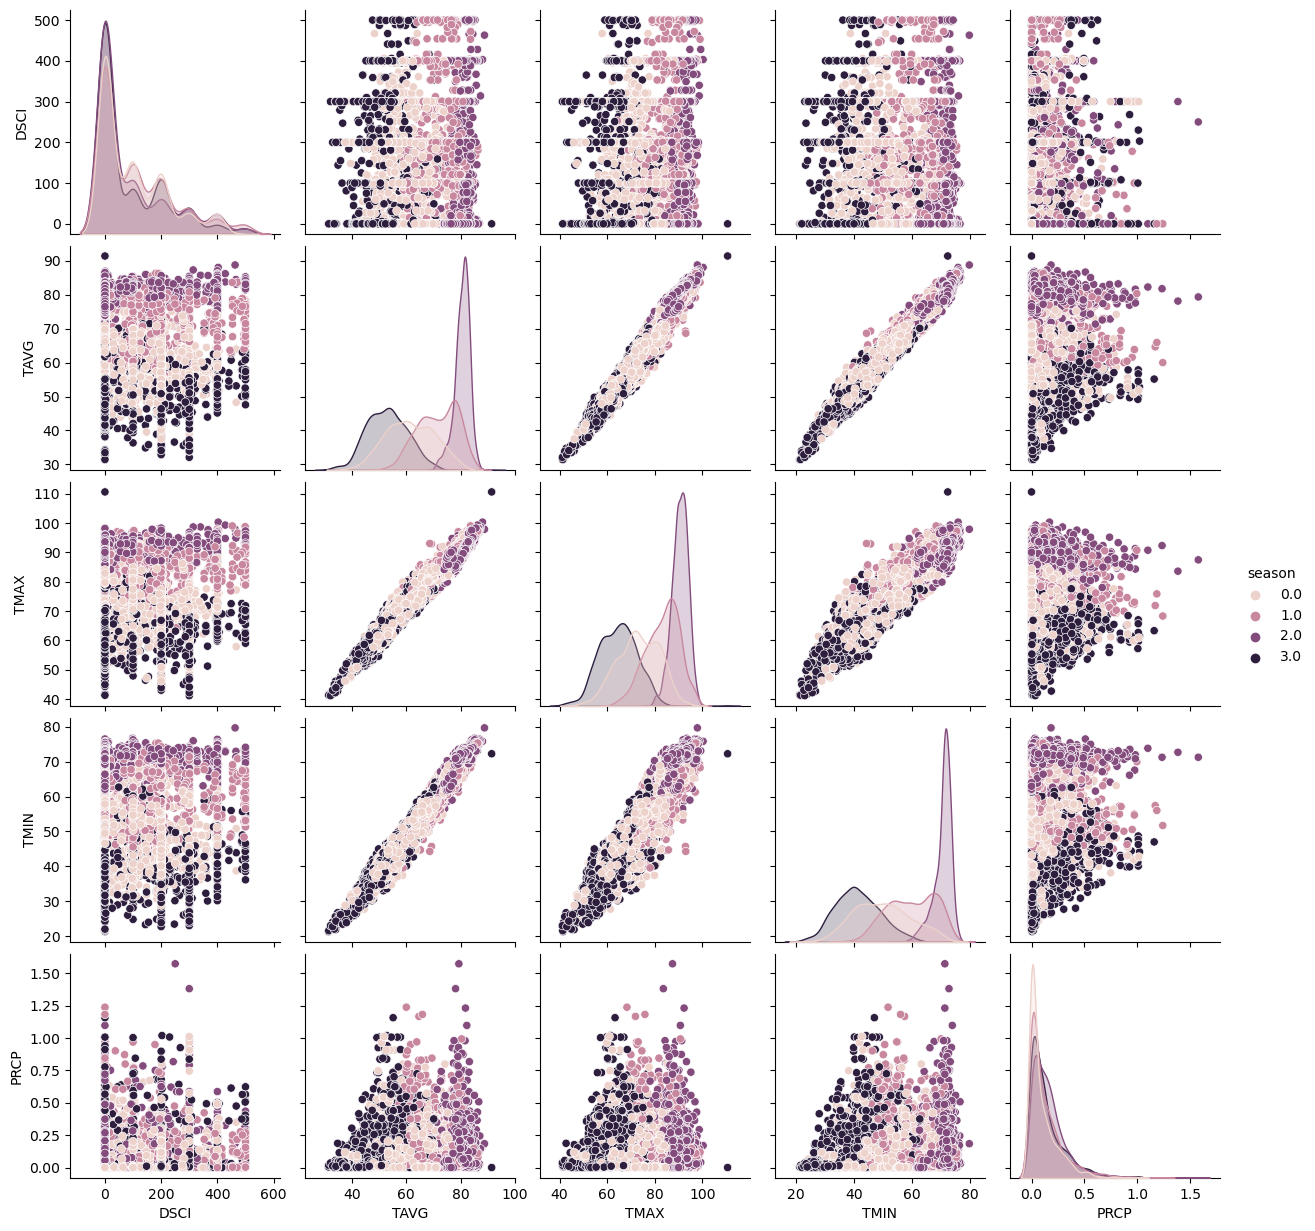

In [125]:
sns.pairplot(df[['DSCI','TAVG','TMAX','TMIN','PRCP','season']],hue='season')

In [126]:
def add_lags(df):
    target_map = df['DSCI'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)
temp = df['DSCI']
df = df.drop(['DSCI'], axis=1)
df['DSCI'] = temp

In [127]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

X_train = train.iloc[:,:-1]
X_test = test.iloc[:,:-1]
y_train = train.iloc[:,-1]
y_test = test.iloc[:,-1]

In [128]:
def objective(args):
    pipe = Pipeline([('scaler', StandardScaler()), ('model', args['model'])])

    X_train_tf = pipe[:-1].fit_transform(X_train)
    X_test_tf = pipe[:-1].fit_transform(X_test)

    pipe[-1].set_params(**args['params'])
    pipe[-1].fit(X_train_tf, y_train,  eval_set=[(X_test_tf, y_test)],
            verbose=0, early_stopping_rounds=10)
    score = cross_val_score(pipe, X, y, cv=5, n_jobs=-1, error_score=0.99)
    return {'loss': 1 - np.median(score), 'status': STATUS_OK}

In [129]:
space = hp.choice('classifiers', [
    {
        'model': xgb.XGBRegressor(),
        'params': {'max_depth': hp.choice("max_depth", [None,2,3,4,6]),
                   'gamma': hp.uniform('gamma', 1, 9),
                   'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
                   'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                   'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
                   'n_estimators': hp.choice('n_estimators', [80,100,200,300,400,500]),
                   'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1, 0.2, 0.3]),
                   'seed': 0,

                   }
    }

])

In [130]:
from hyperopt import space_eval

trials = Trials()

best_classifier = fmin(objective, space, algo=tpe.suggest,
                       max_evals=200, trials=trials)


best_params = space_eval(space, best_classifier)

100%|██████████| 200/200 [04:45<00:00,  1.43s/trial, best loss: 0.9861307985252494]


In [136]:
reg = best_params['model']
reg

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.5359700304791314, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5.388066248975052, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_threshold=64,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
             min_child_weight=3.0, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, ...)

In [134]:
from sklearn.metrics import r2_score

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
X_train = train.iloc[:,:-1]
X_test = test.iloc[:,:-1]
y_train = train.iloc[:,-1]
y_test = test.iloc[:,-1]

xgb_reg_pipe = Pipeline([('scaler',StandardScaler()), ('reg', reg)])

X_train_tf = xgb_reg_pipe[:-1].fit_transform(X_train)
X_test_tf = xgb_reg_pipe[:-1].fit_transform(X_test)

xgb_reg_pipe[-1].fit(X_train_tf, y_train,  eval_set=[(X_test_tf, y_test)],
        verbose=0, early_stopping_rounds=30)


y_pred = reg.predict(X_test_tf)
# model = best_params['model'].fit(X_train_tf, y_train, eval_set=evaluation_2, eval_metric='rmse', early_stopping_rounds=10, verbose=False)
# y_pred = model.predict(X_train_tf)



score = r2_score(y_test, y_pred)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

The accuracy of our model is -9.0%


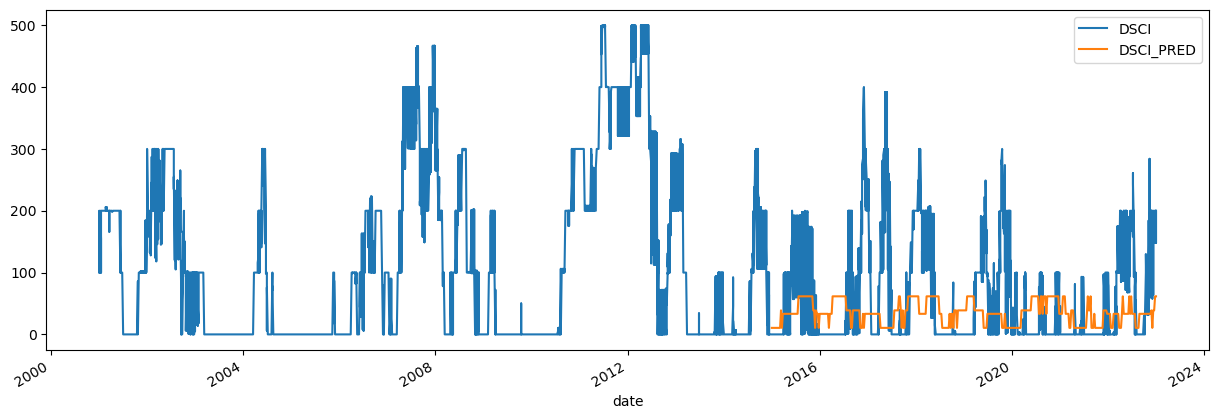

In [135]:
test['DSCI_PRED'] = reg.predict(X_test)
spi_all = pd.concat([train, test], sort=False)

_ = spi_all[['DSCI', 'DSCI_PRED']].plot(figsize=(15, 5))


In [94]:
from sklearn.model_selection import TimeSeriesSplit

[0]	validation_0-rmse:231.33268
[66]	validation_0-rmse:172.75263
[0]	validation_0-rmse:74.99743
[50]	validation_0-rmse:239.83762
[0]	validation_0-rmse:255.58187
[63]	validation_0-rmse:201.63070
[0]	validation_0-rmse:233.09716
[52]	validation_0-rmse:203.07590
[0]	validation_0-rmse:59.86539
[49]	validation_0-rmse:149.10712
[0]	validation_0-rmse:56.48932
[49]	validation_0-rmse:153.07389
[0]	validation_0-rmse:143.66607
[57]	validation_0-rmse:147.95610
[0]	validation_0-rmse:77.50856
[50]	validation_0-rmse:131.33395
[0]	validation_0-rmse:53.88295
[49]	validation_0-rmse:108.28650
[0]	validation_0-rmse:98.37475
[53]	validation_0-rmse:106.02538


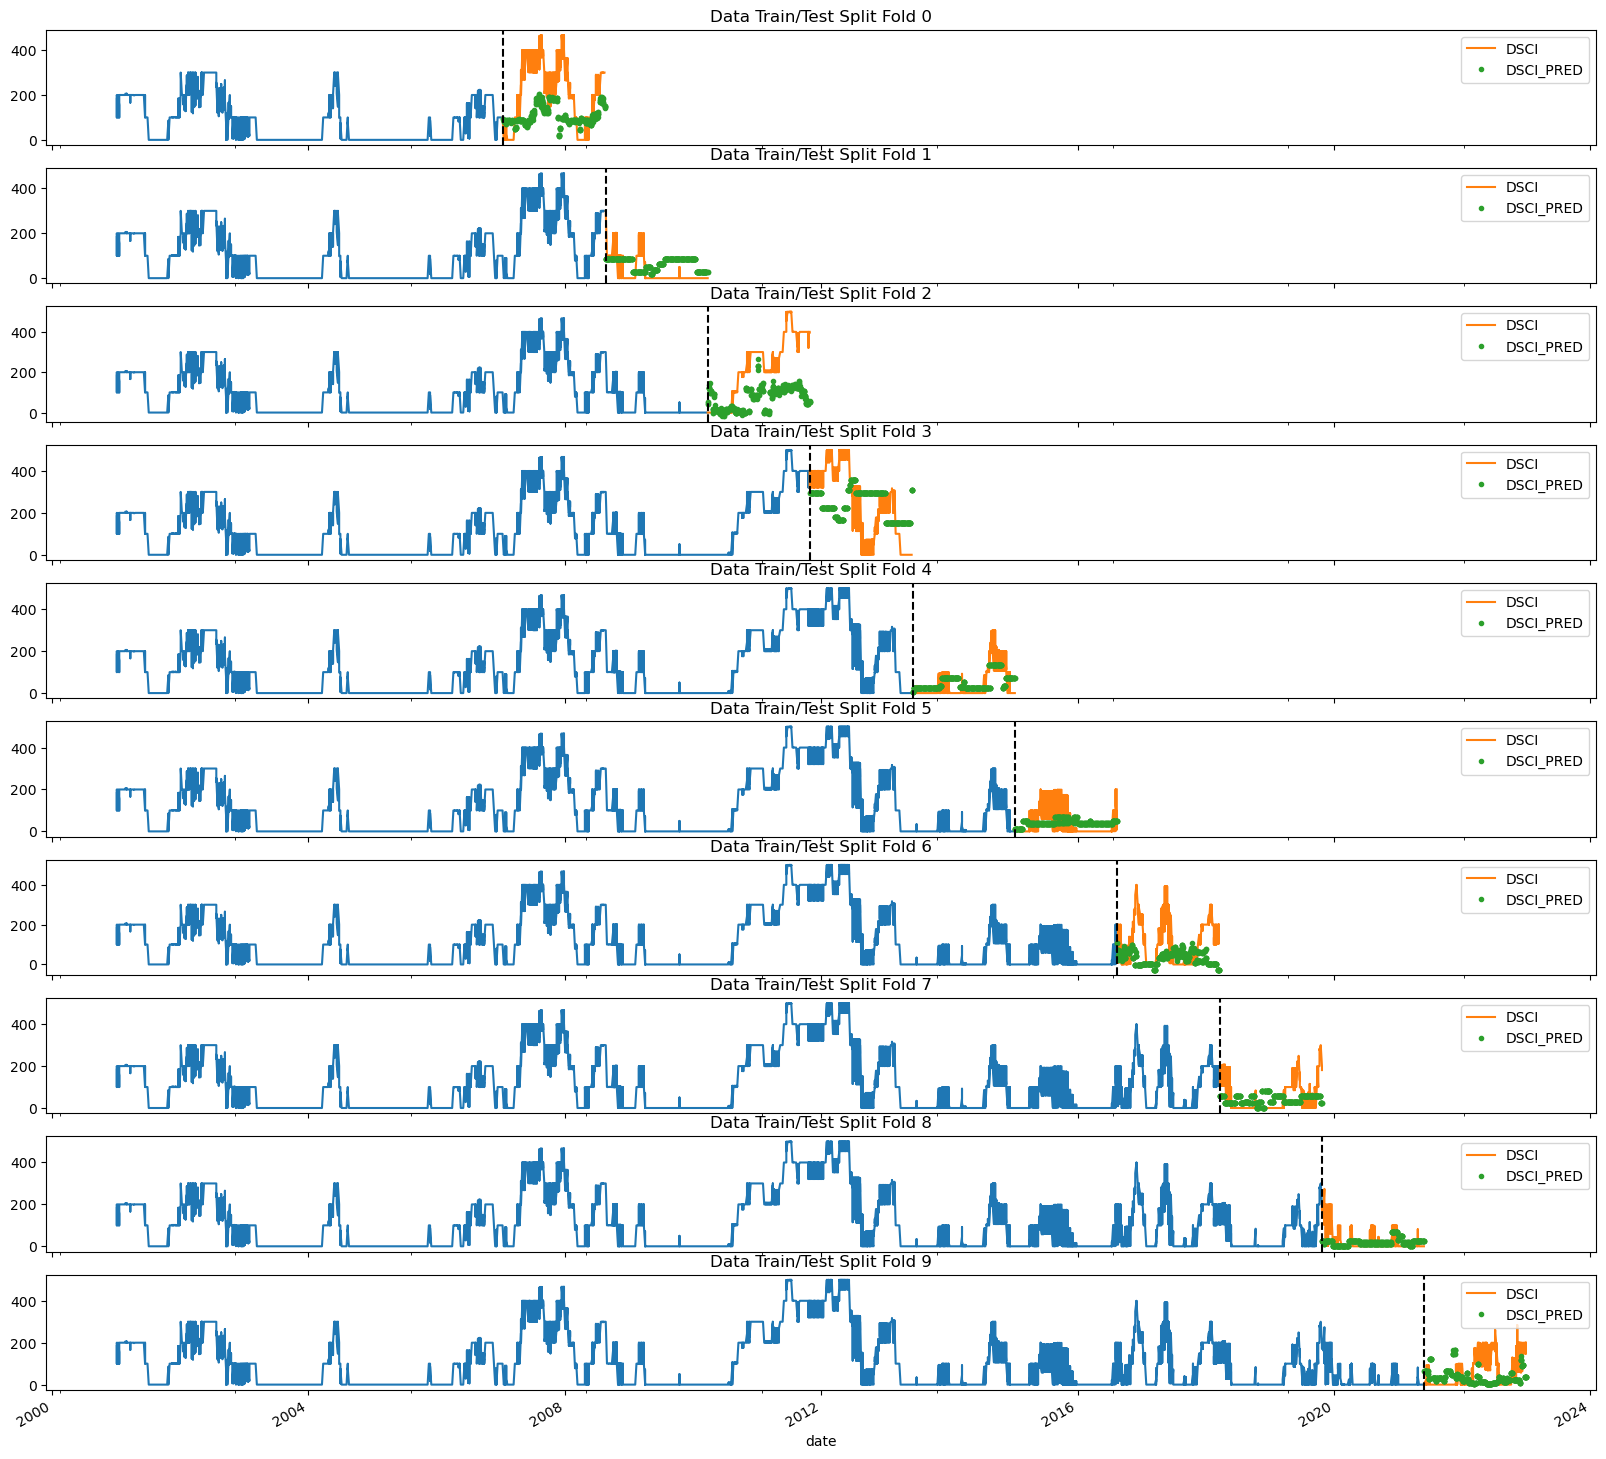

In [95]:

from utils import get_model_acc_via_r2

tss = TimeSeriesSplit(n_splits=10, test_size=500, gap=1)
df = df.sort_index()



fig, axs = plt.subplots(10, 1, figsize=(20, 20), sharex=True)

fold = 0
preds = []
scores = []
accs = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    n_test = test.copy()
    X_train = train.iloc[:,:-1]
    X_test = test.iloc[:,:-1]
    y_train = train.iloc[:,-1]
    y_test = test.iloc[:,-1]



    reg = xgb_reg


    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)], early_stopping_rounds=50,
            verbose=100)

    y_pred = reg.predict(X_test)
    n_test['DSCI_PRED'] = y_pred

    train['DSCI'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    n_test[['DSCI','DSCI_PRED']].plot(ax=axs[fold],
                         label='Test Set',style=['-','.'])
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1


    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    accs.append(get_model_acc_via_r2(y_test, y_pred))

In [66]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_reg, X, y, cv=5, n_jobs=-1)
np.mean(scores)

-0.7163248701497986

In [67]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2, ...)

In [69]:
y_pred = xgb_reg.predict(X_test)

In [73]:
test['DSCI_PRED'] = y_pred
dsci_all = pd.concat([train,test], sort = False)
dsci_all

,county,quarter,month,year,dayofyear,dayofmonth,date_offset,week,season,PRCP,TAVG,TMAX,TMIN,lag1,lag2,lag3,DSCI,DSCI_PRED
date,,,,,,,,,,,,,,,,,,
2001-01-04,0.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,38.857143,52.857143,24.857143,NaN,NaN,NaN,184.0,NaN
2001-01-04,1.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,36.333328,47.869049,24.797619,NaN,NaN,NaN,100.0,NaN
2001-01-04,5.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,36.152386,47.866665,24.438095,NaN,NaN,NaN,200.0,NaN
2001-01-04,3.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,34.857143,46.428570,23.285715,NaN,NaN,NaN,144.0,NaN
2001-01-04,2.0,1.0,1.0,2001.0,2.0,2.0,1082.0,1.0,3.0,0.000000,35.799999,47.621429,23.978571,NaN,NaN,NaN,155.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29,0.0,4.0,12.0,2022.0,361.0,27.0,907.0,52.0,3.0,0.019444,45.962502,59.974998,31.950001,100.0,0.0,0.0,200.0,202.086929
2022-12-29,2.0,4.0,12.0,2022.0,361.0,27.0,907.0,52.0,3.0,0.010278,46.349998,60.066666,32.633335,100.0,0.0,0.0,148.0,171.245560
2022-12-29,3.0,4.0,12.0,2022.0,361.0,27.0,907.0,52.0,3.0,0.003333,44.522232,58.616665,30.427778,100.0,0.0,0.0,200.0,166.106522


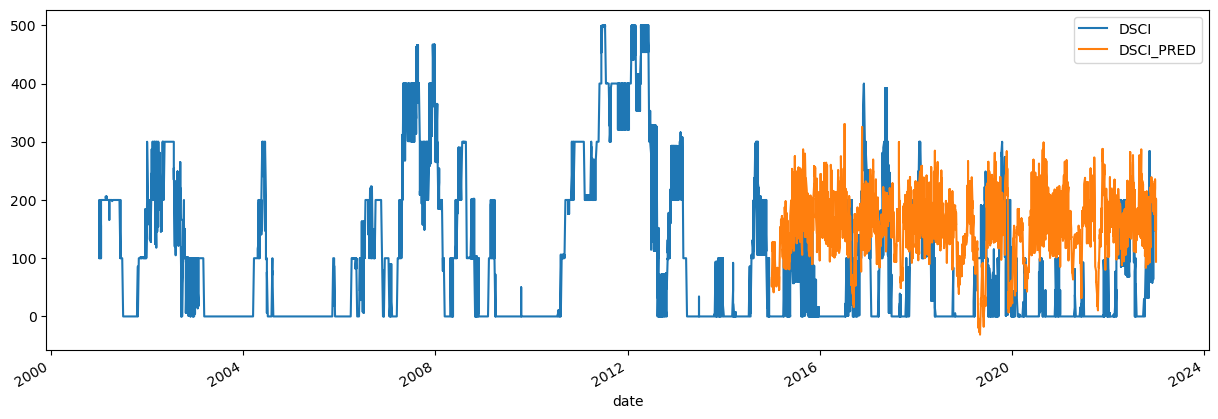

In [74]:

_ = dsci_all[['DSCI','DSCI_PRED']].plot(figsize=(15, 5))

In [47]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

21283.389